# Base VGG training and testing

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Constants (parameters) initialization

In [6]:
device_id = 0
num_workers = 4

batch_size = 128
default_learning_rate = 0.1

## CIFAR-10 data load and preproc

In [7]:
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import PIL.Image as Image
from torch import nn
import numpy as np
import torch.optim as optim
import pandas as pd
import torch
from torchvision import transforms, utils
import torchvision.models as models
import torchvision.datasets as datasets
import os
import random
from tqdm import tqdm as tqdm
from IPython import display

Make sure you are using the right device.

In [11]:
device_id = device_id
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]=str(device_id)

device = torch.device("cuda:{}".format(device_id) if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device_id))

cuda:0
GeForce GTX 1080 Ti


In [12]:
class PartialDataset(Dataset):
    def __init__(self, dataset, n_items=10):
        self.dataset = dataset
        self.n_items = n_items
        
    def __getitem__(self):
        return self.dataset.__getitem__()
    
    def __len__(self):
        return min(self.n_items, len(self.dataset))

In [35]:
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                 std=[0.5, 0.5, 0.5])
train_transform = transforms.Compose(
    [#transforms.RandomHorizontalFlip(),
    #transforms.RandomCrop(32, 4),
    transforms.ToTensor(),
    normalize
    ])
val_transform = transforms.Compose(
    [transforms.ToTensor(),
    normalize
    ])

dataset_train = datasets.CIFAR10(root='../data/', train=True, download=True, transform=train_transform)
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)

dataset_val = datasets.CIFAR10(root='../data/', train=False, download=True, transform=val_transform)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True, num_workers=num_workers)


n_items = 10
dataset_train_part = PartialDataset(dataset_train, n_items)
train_loader_part = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Make sure that dataloader works as expected by observing one sample from it.

tensor([[[0.9725, 0.9569, 0.9529,  ..., 0.9294, 0.9294, 0.9294],
         [0.9686, 0.9569, 0.9529,  ..., 0.9216, 0.9216, 0.9216],
         [0.9686, 0.9529, 0.9529,  ..., 0.9176, 0.9176, 0.9216],
         ...,
         [0.5373, 0.5137, 0.5255,  ..., 0.4000, 0.4627, 0.4824],
         [0.5373, 0.5098, 0.5216,  ..., 0.5373, 0.5490, 0.5255],
         [0.4471, 0.4431, 0.4549,  ..., 0.4392, 0.4706, 0.4863]],

        [[0.9961, 0.9804, 0.9765,  ..., 0.9490, 0.9490, 0.9490],
         [0.9922, 0.9804, 0.9765,  ..., 0.9412, 0.9412, 0.9412],
         [0.9922, 0.9765, 0.9725,  ..., 0.9373, 0.9373, 0.9412],
         ...,
         [0.6157, 0.5922, 0.6039,  ..., 0.3765, 0.4706, 0.5255],
         [0.6353, 0.6078, 0.6196,  ..., 0.5255, 0.5529, 0.5490],
         [0.5922, 0.5922, 0.6039,  ..., 0.4745, 0.5098, 0.5255]],

        [[0.9882, 0.9725, 0.9686,  ..., 0.9216, 0.9216, 0.9216],
         [0.9843, 0.9725, 0.9686,  ..., 0.9137, 0.9137, 0.9137],
         [0.9843, 0.9686, 0.9686,  ..., 0.9137, 0.9137, 0.

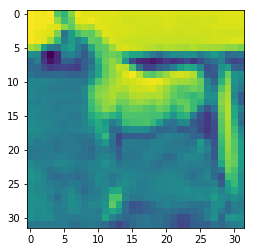

In [23]:
for X,y in train_loader:
    print(X[0])
    print(y[0])
    print(X[0].shape)
    plt.imshow(np.array(X[0,0,:,:]))
    print(X[0].max())
    print(X[0].min())
    break

## Models implementation

In [15]:
def get_number_of_parameters(model):
    parameters_n = 0
    for parameter in model.parameters():
        parameters_n += np.prod(parameter.shape).item()
        
    return parameters_n

In [16]:
class VGG_A(nn.Module):
    def __init__(self, inp_ch=3, num_classes=10):
        super().__init__()
        
        self.stage1 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.classifier = nn.Sequential(
            nn.Linear(512*1*1, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes))
       

    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)
        x = self.classifier(x.view(-1, 512*1*1))
        return x
    
    
class VGG_A_Light(nn.Module):
    def __init__(self, inp_ch=3, num_classes=10):
        super().__init__()
        
        self.stage1 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        '''
        self.stage3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        '''
        self.classifier = nn.Sequential(
            nn.Linear(32*8*8, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))
       

    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        #x = self.stage3(x)
        #x = self.stage4(x)
        #x = self.stage5(x)
        x = self.classifier(x.view(-1, 32*8*8))
        return x
    
    
class VGG_A_Dropout(nn.Module):
    def __init__(self, inp_ch=3, num_classes=10):
        super().__init__()
        
        self.stage1 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512*1*1, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, num_classes))
       

    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)
        x = self.classifier(x.view(-1, 512*1*1))
        return x

print(get_number_of_parameters(VGG_A()))

9750922


## Final preparations for training

In [17]:
def train(model, 
          optimizer, 
          criterion,  
          train_loader, 
          val_loader, 
          scheduler=None, 
          epochs_n=100, 
          best_model_path=None):
    
    model.to(device)
    learning_curve = [np.nan] * epochs_n
    train_accuracy_curve = [np.nan] * epochs_n
    val_accuracy_curve = [np.nan] * epochs_n
    max_val_accuracy = 0
    max_val_accuracy_epoch = 0

    batches_n = len(train_loader)

    for epoch in tqdm(range(epochs_n), unit='epoch'):
        if scheduler is not None:  
            scheduler.step()       
        model.train()

        learning_curve[epoch] = 0
        for data in train_loader:
            x, y = data
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            prediction = model(x)
            loss = criterion(prediction, y)
            learning_curve[epoch] += loss.item()
            loss.backward()
            optimizer.step()
        
        display.clear_output(wait=True)
        f, axes = plt.subplots(1, 2, figsize=(15, 3))

        learning_curve[epoch] /= batches_n
        axes[0].plot(learning_curve)

        model.eval()
        train_accuracy_curve[epoch] = get_accuracy(model, train_loader, device)
        val_accuracy_curve[epoch] = get_accuracy(model, val_loader, device)
        
        val_accuracy = val_accuracy_curve[epoch]
        if val_accuracy > max_val_accuracy:
            max_val_accuracy = val_accuracy
            max_val_accuracy_epoch = epoch
            if best_model_path:
                torch.save(model.state_dict(), best_model_path)
        
        axes[1].set_title('Train {:.4f}, val {:.4f}, max val {:.4f} at {}'.format(
            train_accuracy_curve[epoch], val_accuracy, max_val_accuracy, max_val_accuracy_epoch))
        axes[1].plot(train_accuracy_curve)
        axes[1].plot(val_accuracy_curve)

        plt.tight_layout()
        plt.show()

In [18]:
def get_accuracy(model, dataloader, device='cpu'):
    correct = 0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)  ## <---
            y = y.to(device)  ## <---
            prediction = model(x).argmax(dim=-1, keepdim=True)
            correct += prediction.eq(y.view_as(prediction)).sum().item()
    return correct / len(dataloader.dataset)

In [19]:
def set_random_seeds(seed_value=0, device='cpu'):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if device != 'cpu': 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

## Training

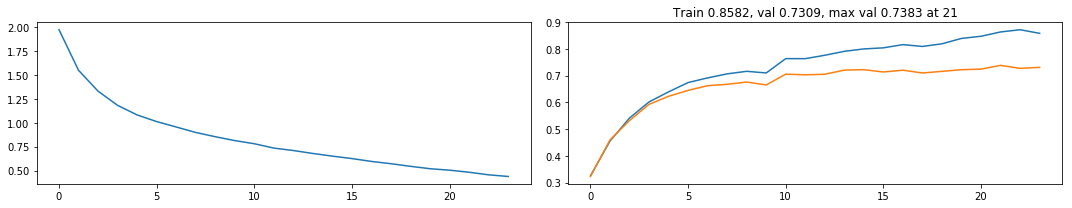







 48%|████▊     | 24/50 [06:13<06:35, 15.20s/epoch]

In [ ]:
os.path.join(os.getcwd(), 'best_vgg_1.pt') #change dump name here

set_random_seeds(seed_value=1984, device=device)
model = VGG_A()
lr = default_learning_rate
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

train(model, 
      optimizer, 
      criterion, 
      train_loader,
      val_loader,
      epochs_n=50, 
      best_model_path=model_path)
